# 学习笔记：Diffusion and Score-Based Generative Models

## 数学基础

### 随机微分方程
考虑一个ode:
$$dX(t)=μ(X(t),t)dt$$
这时，我们可以通过加入一个带系数的噪声项来将其转化为一个随机微分方程：
$$\downarrow \text{加入高斯噪声} dW(t)\sim N(0,dt)$$
$$dX(t)=μ(X(t),t)dt+σ(X(t),t)dW(t)$$
这时 $X(t)$ 表示一个随机过程，$\mu$ 和 $\sigma$ 不带有随机性。

考虑一个简单的SDE（布朗运动）:
$$dX(t)=dW(t)$$
取时间步长为1时则有 $X(t+1) - X(t) \sim N(0,1)$

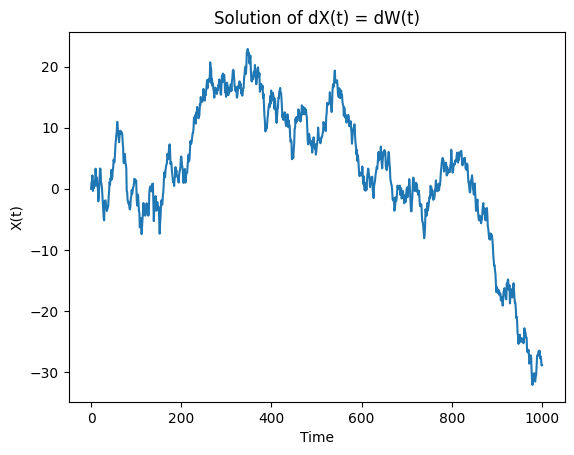

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def brownian_motion():
    T = 1000  # 总时间
    N = 1000  # 步数
    dt = T / N  # 时间步长

    # 模拟布朗运动
    X = np.zeros(N)
    for i in range(1, N):
        X[i] = X[i - 1] + np.sqrt(dt) * np.random.normal()

    # 绘制图像
    t = np.linspace(0, T, N)
    plt.plot(t, X)
    plt.xlabel('Time')
    plt.ylabel('X(t)')
    plt.title('Solution of dX(t) = dW(t)')
    plt.show()

brownian_motion()

### 朗之万动力学
Langevin 动力学描述的是例子在势能场中的运动，可以把损失函数视为一个势能场，因此：
$$dX(t)=\overbrace{\nabla [-\log p(x)]}^{得分函数}+\sqrt{2D}dW(t)$$

得分函数：可以描述概率的变化率，并且求梯度后可以消掉归一化常数项，使我们在不知道具体分布函数但了解分布概率相对大小的情况下，仍可以求解。

_Langevin 动力学示例_

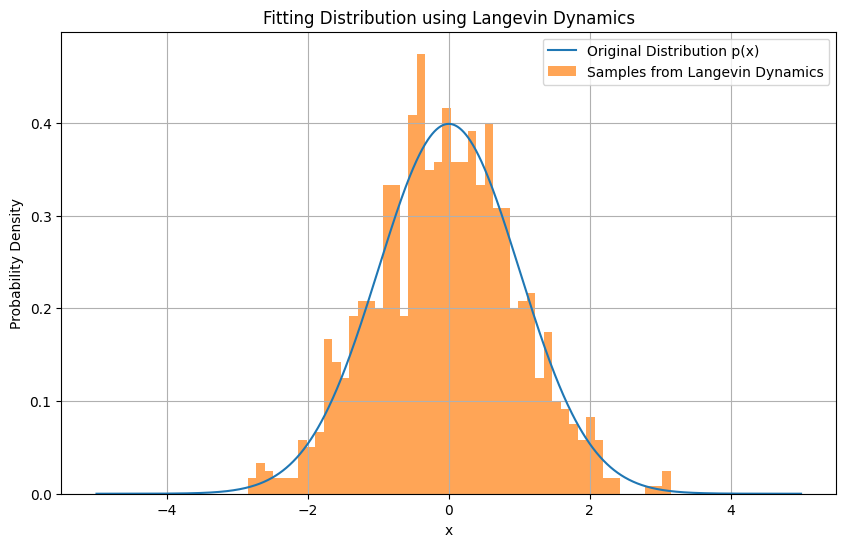

In [3]:
from scipy.stats import norm
import numpy as np

# 定义目标分布 p(x)，这里以标准正态分布为例
def target_distribution(x):
    return norm.pdf(x, loc=0, scale=1)

# 计算目标分布的对数概率的梯度
def log_prob_gradient(x):
    # 对于标准正态分布，对数概率的梯度为 -x
    return -x

# 朗之万动力学采样
def langevin_dynamics(num_samples, num_steps, step_size):
    samples = np.zeros((num_samples, num_steps))
    # 初始化样本
    samples[:, 0] = np.random.normal(size=num_samples)
    for i in range(num_samples):
        for t in range(1, num_steps):
            # 朗之万动力学更新规则
            noise = np.random.normal()
            samples[i, t] = samples[i, t - 1] + 0.5 * step_size * log_prob_gradient(samples[i, t - 1]) + np.sqrt(step_size) * noise
    return samples[:, -1]

# 参数设置
num_samples = 1000  # 采样的样本数量
num_steps = 1000    # 迭代步数
step_size = 0.1     # 步长

# 进行朗之万动力学采样
samples = langevin_dynamics(num_samples, num_steps, step_size)

# 绘制原始分布和采样得到的分布
x = np.linspace(-5, 5, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, target_distribution(x), label='Original Distribution p(x)')
plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples from Langevin Dynamics')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Fitting Distribution using Langevin Dynamics')
plt.legend()
plt.grid(True)
plt.show()

Langevin 动力学的思想：利用梯度函数引导样本向高概率区域移动，同时避免陷入局部最优（因为有随机项的存在，粒子不会被锁死在一个地方），以及避免在低概率区域的拟合效果过差。

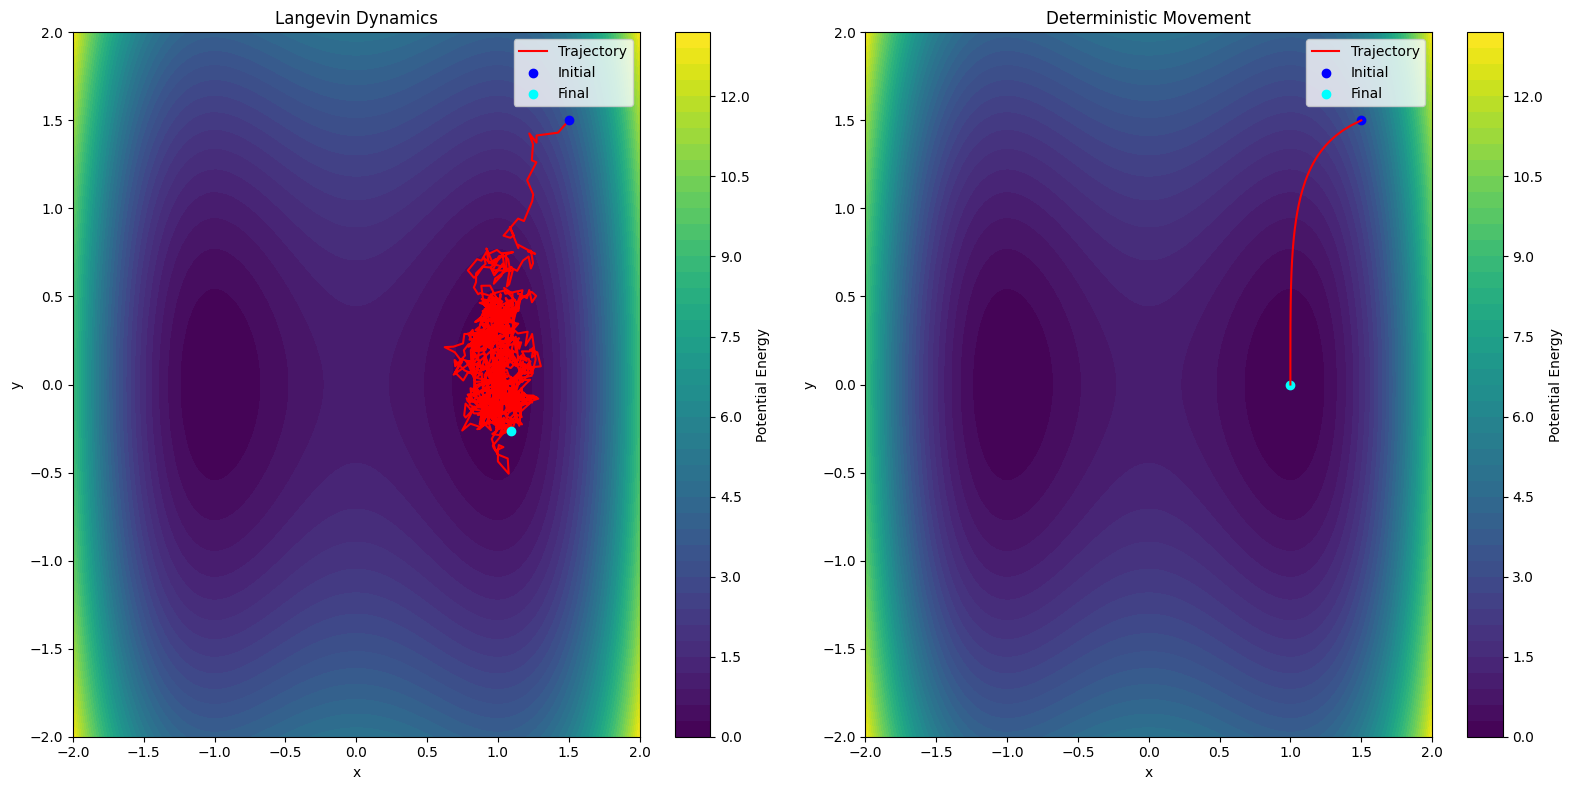

In [4]:

# 定义势能场函数
def potential(x, y):
    return (x**2 - 1)**2 + y**2

# 计算势能场的梯度
def gradient(x, y, h=1e-5):
    dx = (potential(x + h, y) - potential(x - h, y)) / (2 * h)
    dy = (potential(x, y + h) - potential(x, y - h)) / (2 * h)
    return np.array([dx, dy])

# Langevin 动力学模拟
def langevin_dynamics(num_steps, dt, gamma, kT, initial_position):
    positions = [initial_position]
    current_position = np.array(initial_position, dtype=np.float64)

    for _ in range(num_steps):
        grad = gradient(*current_position)
        noise = np.random.normal(0, np.sqrt(2 * kT * gamma * dt), 2)
        current_position = current_position - dt * grad / gamma + noise
        positions.append(current_position)
    return np.array(positions)

# 确定性移动模拟（仅按梯度）
def deterministic_movement(num_steps, dt, gamma, initial_position):
    positions = [initial_position]
    current_position = np.array(initial_position, dtype=np.float64)

    for _ in range(num_steps):
        grad = gradient(*current_position)
        current_position = current_position - dt * grad / gamma
        positions.append(current_position)
    return np.array(positions)

def Langevin(initial_position = [1.5, 1.5]):
    # 参数设置
    num_steps = 1000
    dt = 0.01
    gamma = 1.0
    kT = 0.1


    # 运行模拟
    langevin_trajectory = langevin_dynamics(num_steps, dt, gamma, kT, initial_position)
    deterministic_trajectory = deterministic_movement(num_steps, dt, gamma, initial_position)

    # 生成势能场网格数据
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential(X, Y)

    # 创建两个子图
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 绘制 Langevin 动力学图
    ax1 = axes[0]
    contour1 = ax1.contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(contour1, ax=ax1, label='Potential Energy')
    ax1.plot(langevin_trajectory[:, 0], langevin_trajectory[:, 1], 'r-', label='Trajectory')
    ax1.scatter(langevin_trajectory[0, 0], langevin_trajectory[0, 1], color='blue', marker='o', label='Initial',zorder=3)
    ax1.scatter(langevin_trajectory[-1, 0], langevin_trajectory[-1, 1], color='cyan', marker='o', label='Final', zorder=3)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Langevin Dynamics')
    ax1.legend()

    # 绘制确定性移动图
    ax2 = axes[1]
    contour2 = ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(contour2, ax=ax2, label='Potential Energy')
    ax2.plot(deterministic_trajectory[:, 0], deterministic_trajectory[:, 1], 'r-', label='Trajectory')
    ax2.scatter(deterministic_trajectory[0, 0], deterministic_trajectory[0, 1], color='blue', marker='o', label='Initial')
    ax2.scatter(deterministic_trajectory[-1, 0], deterministic_trajectory[-1, 1], color='cyan', marker='o', label='Final')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Deterministic Movement')
    ax2.legend()

    plt.tight_layout()
    plt.show()
Langevin()

下图展示了朗之万动力学可以避免陷入局部最优解。（起始点梯度为0）

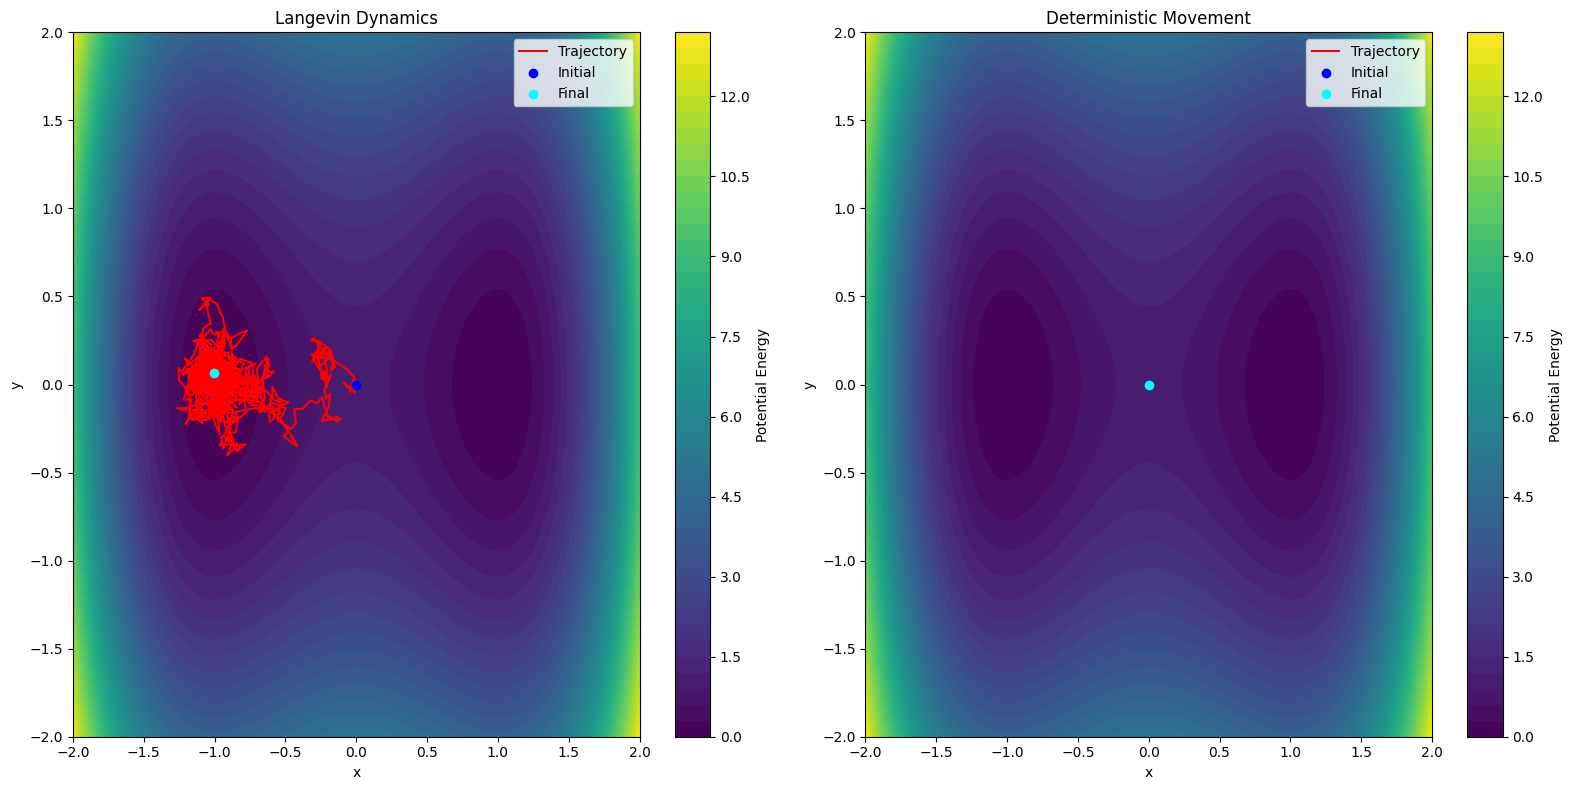

In [5]:
Langevin([0,0])

## 得分函数：建模与训练

在概率建模问题中，我们往往利用一个神经网络的输出 $y$ 来表示各种可能情况对应的概率，即它对应一个概率分布 $p(x)$。然而神经网络的输出值往往是不符合概率论公理的，为了能够使用概率论的方法来分析，就需要对其进行一些变换，使得其符合概率分布的要求。比如归一化常数 $Z$，但是往往计算归一化常数是复杂的，因此对于客观的拟合目标 $p(x)$，定义得分函数
$$s(x) = -\nabla_x \log p(x)$$
该函数保留了 $p(x)$ 的全部信息，并且可以通过神经网络来拟合。由于
$$-\nabla_x \log p(x)=-\nabla_x \log \frac{y(x)}{Z}=-\nabla_x \log y(x)$$
我们可以略去繁杂的归一化常数的计算，从而只需要训练 $s_{\theta}(x)$ 并利用它来生成图像。

得分函数的意义是，其方向是 $x$ 变化最快的方向，y

### 得分匹配

我们可以通过比较 $s(x)$ 和 $s_{\theta}(x)$ 来作为损失函数：（可以理解为求矢量差的平均模长）
$$\frac{1}{2}\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}[\|\underbrace{\nabla_{\mathbf{x}}\log p_{\mathrm{data}}(\mathbf{x})}_{\text{Unknown}}-s_{\boldsymbol{\theta}}(\mathbf{x})\|_{2}^{2}]~~~\text{(Fisher divergence)}$$

为了能够进行计算，采取前人的 __得分匹配__ 算法将上式化为
$$\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}\left[\frac{1}{2}\left\|s_{\theta}(\mathbf{x})\right\|_{2}^{2}+\mathrm{trace}(\underbrace{\nabla_{\mathrm{x}}s_{\theta}(\mathbf{x})}_{\text{Jacobian of }s_{\theta}(\mathbf{x})})\right]\approx\frac{1}{N}\sum_{i=1}^{N}\left[\frac{1}{2}\left\|s_{\theta}(\mathbf{x}_{i})\right\|_{2}^{2}+\mathrm{trace}\left(\nabla_{\mathbf{x}}s_{\theta}(\mathbf{x}_{i})\right)\right]$$
其中 $\text{trace}$ 表示迹。

#### 切片得分匹配 (Sliced Score Matching)
> 在机器学习中 $\mathbb{E}_{x\sim p}[y(x)] := \int_{X}y(x)p(x)\text{d} x$

上面的公式的问题就在于维度越高，在计算迹时需要的反向传播的次数就越多。因此我们采用一种思想：降维。因为如果两个向量彼此靠近，他们在某个直线上的投影也会非常接近。
$$\frac{1}{2}\mathbb{E}_{p_{\mathbf{v}}}\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}[(\mathbf{v}^\intercal\nabla_\mathbf{x}\log p_{\mathrm{data}}(\mathbf{x})-\mathbf{v}^\intercal\mathrm{s}_\theta(\mathbf{x}))^2]$$

接下来展开平方项：
$$=\frac{1}{2}\mathbb{E}\left[(\mathbf{v}^\intercal\nabla\log p_\mathrm{data})^2-2(\mathbf{v}^\intercal\nabla\log p_\mathrm{data})(\mathbf{v}^\intercal s_\theta)+(\mathbf{v}^\intercal s_\theta)^2\right]$$

处理交叉项，利用分部积分：
$$\begin{aligned}&\mathbb{E}_{p_{\mathrm{data}}}\left[\mathbf{v}^\intercal\nabla\log p_{\mathrm{data}}\cdot f(\mathbf{x})\right]\\
&=\int \left[\mathbf{v}^\intercal\nabla\log p_{\mathrm{data}}\cdot f(\mathbf{x})\right]p_{data}(\mathbf{x})d\mathbf{x}~~~\text{(把梯度放进去)}\\
&=\int \mathbf{v}^\intercal\cdot\left[f(\mathbf{x})\right]p_{data}(\mathbf{x})d\log p_{data}(\mathbf{x})\\
&=\underbrace{\mathbf{v}^\intercal\cdot\left[f(\mathbf{x})\right]\log p_{data}(\mathbf{x})p_{data}(\mathbf{x})\mid_{X}}_{\text{根据密度函数在无穷远处趋于0，该项为0}} -\mathbb{E}_{p_{\mathrm{data}}}\left[\mathbf{v}^\intercal\nabla f(\mathbf{x})\right]\\
&=-\mathbb{E}_{p_{\mathrm{data}}}\left[\mathbf{v}^\intercal\nabla f(\mathbf{x})\right]
\end{aligned}$$

代入原式，并忽略掉与 $\theta$ 无关的项，根据 $\nabla \mathbf{v}^\intercal s_{\theta}(\mathbf{x})=\nabla [s_{\theta}(\mathbf{x})] \mathbf{v}  $ 有：
$$\mathbb{E}_{p_{\mathbf{v}}} \mathbb{E}_{p_{\text{data}}} \left[ \mathbf{v}^\top \nabla_{\mathbf{x}} s_\theta \mathbf{v} + \frac{1}{2} \left( \mathbf{v}^\top s_\theta \right)^2 \right]$$
__这是我们新的损失函数__，其中 $\mathbf{v}$ 是一个随机向量，通常取正态分布或均匀分布。相比于直接计算迹，这个只需要在完成前向传播后计算一步向量内积，再在反向传播后计算一次向量内积。一共就多了两步。

#### 去噪得分匹配 (Denoising Score Matching)
参考 [知乎回答](https://www.zhihu.com/question/487904648/answer/3057023165) 我们将目标变为去除噪声。

## 生成模型

### 朗之万动力学采样 (Langevin Dynamics Sampling)

如何从得分函数中获得样本呢？一种想法是从得分函数（一个势能场）中采样，然后利用梯度下降将样本点（粒子）引导到高概率值的点。
为了防止样本点全部收敛到一处，我们引入维纳过程项，即朗之万随机微分方程。

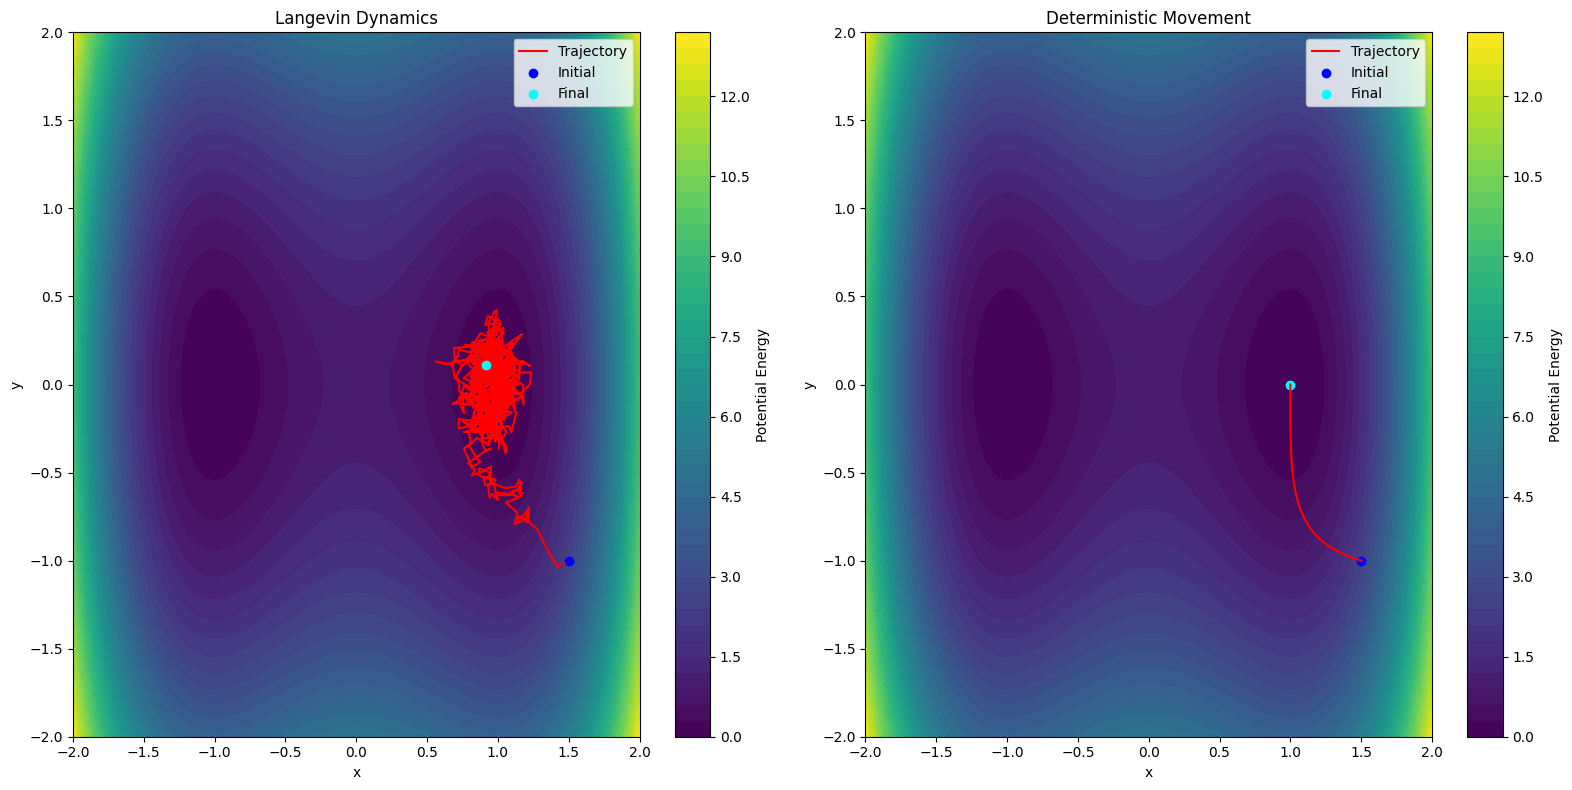

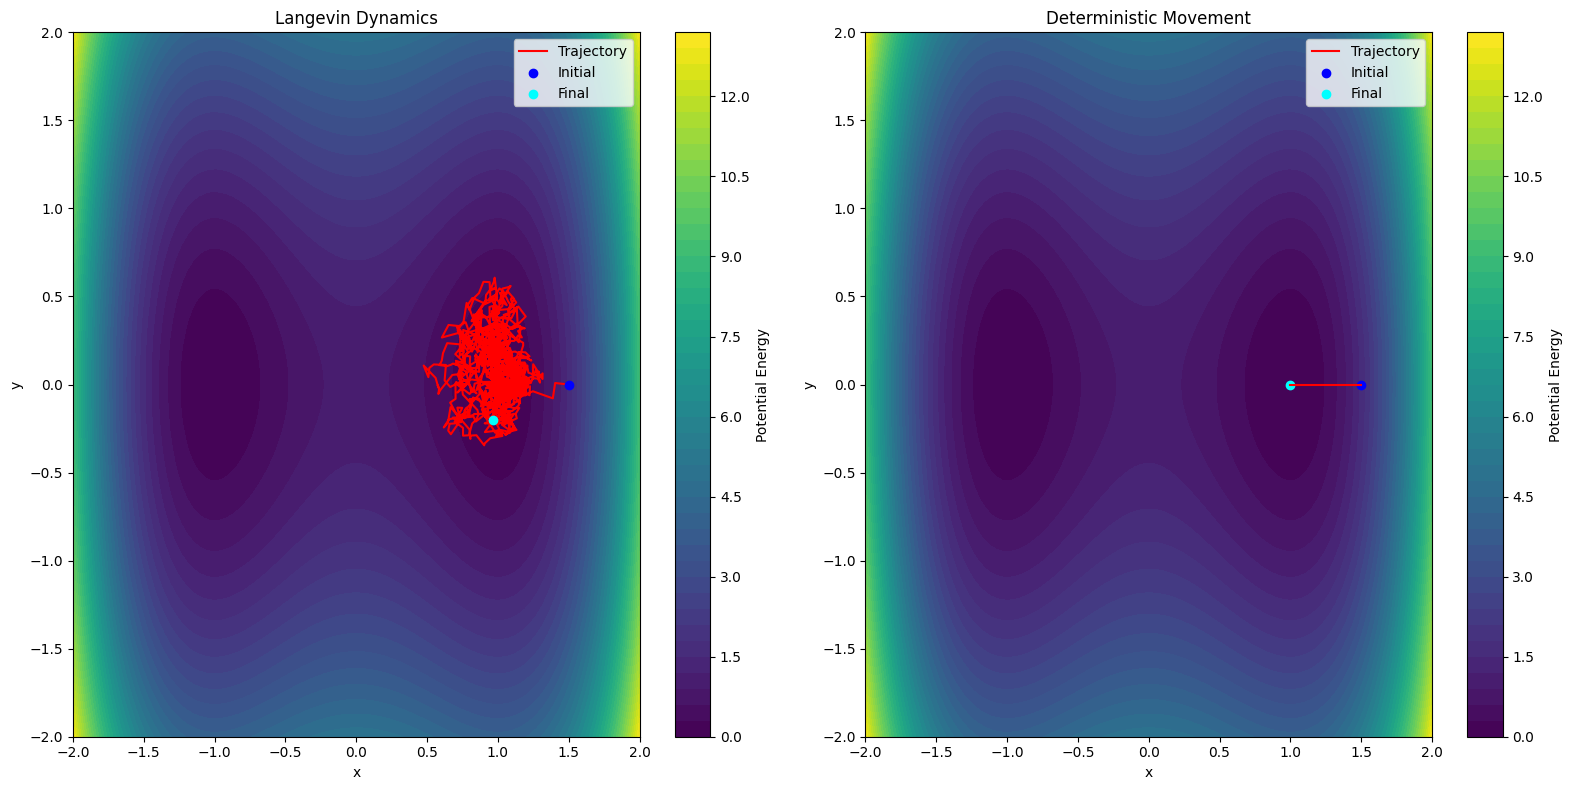

In [6]:
Langevin([1.5,-1])
Langevin([1.5,0])

然而仅仅这样是不够的，因为得分函数

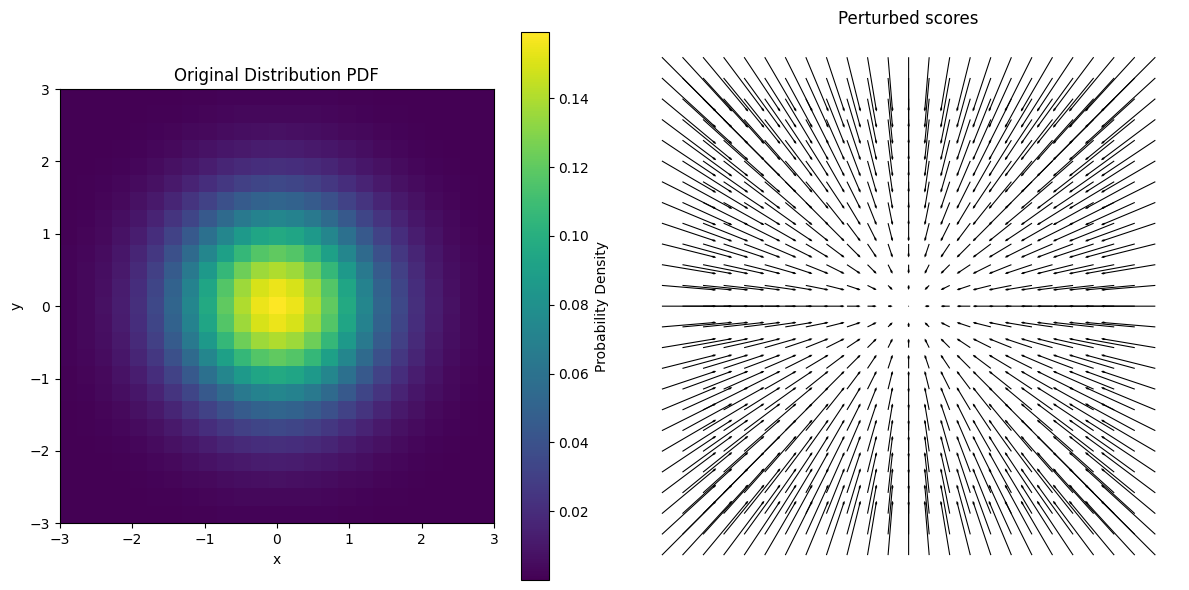

In [7]:
# 定义二维正态分布参数（示例参数）
mu_x, mu_y = 0, 0
sigma_x, sigma_y = 1, 1
rho = 0

# 减少网格点数，让图像更简洁
x = np.linspace(-3, 3, 25)
y = np.linspace(-3, 3, 25)
X, Y = np.meshgrid(x, y)

# 计算二维正态分布的概率密度函数
z_x = (X - mu_x) / sigma_x
z_y = (Y - mu_y) / sigma_y
denom = 1 - rho ** 2
exponent = -0.5 / denom * (z_x ** 2 - 2 * rho * z_x * z_y + z_y ** 2)
pdf = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(denom)) * np.exp(exponent)

# 计算梯度（得分函数）
L_x = - (z_x - rho * z_y) / (sigma_x * denom)
L_y = - (z_y - rho * z_x) / (sigma_y * denom)

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 绘制原始分布概率密度函数的热力图
im = axes[0].imshow(pdf, cmap='viridis', origin='lower', extent=[-3, 3, -3, 3])
axes[0].set_title('Original Distribution PDF', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
fig.colorbar(im, ax=axes[0], label='Probability Density')

# 绘制简洁箭头图
# 调整箭头样式：更细、颜色深灰
q = axes[1].quiver(X, Y, L_x, L_y,
                   scale=30,  # 调整箭头长度比例
                   color='black',
                   width=0.002,  # 箭头线宽更细
                   headwidth=2,  # 箭头头部更小
                   headlength=2)
axes[1].set_title('Perturbed scores', fontsize=12)
axes[1].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# 定义二维正态分布的真实得分函数（理论值：-x）
def true_score_function(x):
    return x

# 定义神经网络模型
class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        return self.layers(x)

# 实现投影损失函数（切片得分匹配损失）
def projection_loss(net, x, v):
    # 获取模型预测的得分函数
    s_theta = net(x)
    
    # 计算 v^T ∇_x s_θ v
    x.requires_grad_(True)
    v_s_theta = torch.sum(v * s_theta, dim=1)  # 计算 v^T s_θ
    
    # 显式传递 grad_outputs 并处理 None 情况
    grad_outputs = torch.ones_like(v_s_theta.sum())
    grad_v_s_theta = torch.autograd.grad(
        outputs=v_s_theta.sum(),
        inputs=x,
        grad_outputs=grad_outputs,
        create_graph=True,
        allow_unused=True
    )[0]
    
    # 处理 grad_v_s_theta 为 None 的情况
    if grad_v_s_theta is None:
        grad_v_s_theta = torch.zeros_like(x)
    
    v_grad_s_theta_v = torch.sum(v * grad_v_s_theta * v, dim=1)  # v^T ∇_x s_θ v
    
    # 计算损失项
    loss_term = v_grad_s_theta_v + 0.5 * (v_s_theta ** 2)
    loss = loss_term.mean()
    x.requires_grad_(False)
    return loss

if 1:
    # 初始化模型与优化器
    net = ScoreNetwork()
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    # 训练参数
    num_epochs = 10000
    batch_size = 256
    
    for epoch in range(num_epochs):
        # 采样二维正态分布数据
        x = torch.randn(batch_size, 2)
        # 采样随机向量 v（正态分布）
        v = torch.randn_like(x)
        
        # 计算损失并更新模型
        optimizer.zero_grad()
        loss = projection_loss(net, x, v)
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            with torch.no_grad():
                x_test = torch.tensor([[1.0, 2.0]])
                pred_score = net(x_test)
                true_score = true_score_function(x_test)
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, "
                      f"Pred Score: {pred_score}, True Score: {true_score}")

Epoch 0, Loss: 0.0395, Pred Score: tensor([[0.2659, 0.0376]]), True Score: tensor([[1., 2.]])
Epoch 1000, Loss: 0.0000, Pred Score: tensor([[-0.0022, -0.0002]]), True Score: tensor([[1., 2.]])
Epoch 2000, Loss: 0.0000, Pred Score: tensor([[-0.0009,  0.0016]]), True Score: tensor([[1., 2.]])
Epoch 3000, Loss: 0.0000, Pred Score: tensor([[-0.0022,  0.0035]]), True Score: tensor([[1., 2.]])
Epoch 4000, Loss: 0.0000, Pred Score: tensor([[0.0002, 0.0009]]), True Score: tensor([[1., 2.]])
Epoch 5000, Loss: 0.0000, Pred Score: tensor([[-1.0261e-03, -6.8573e-05]]), True Score: tensor([[1., 2.]])
Epoch 6000, Loss: 0.0000, Pred Score: tensor([[-1.2451e-04,  3.7272e-05]]), True Score: tensor([[1., 2.]])
Epoch 7000, Loss: 0.0000, Pred Score: tensor([[ 0.0001, -0.0005]]), True Score: tensor([[1., 2.]])
Epoch 8000, Loss: 0.0000, Pred Score: tensor([[ 0.0003, -0.0002]]), True Score: tensor([[1., 2.]])
Epoch 9000, Loss: 0.0000, Pred Score: tensor([[ 0.0012, -0.0015]]), True Score: tensor([[1., 2.]])


In [9]:
test1 = torch.tensor([[0.0,0.0]])
test2 = torch.tensor([[1.0,1.0]])
print(f"Pre:{net(test1)}  True:{true_score_function(test1)}")
print(f"Pre:{net(test2)}  True:{true_score_function(test2)}")

Pre:tensor([[-0.0006,  0.0003]], grad_fn=<AddmmBackward0>)  True:tensor([[0., 0.]])
Pre:tensor([[-0.0003,  0.0006]], grad_fn=<AddmmBackward0>)  True:tensor([[1., 1.]])


可以看出，总体上，我们的神经网络对原始分布的拟合程度并不好：在高密度区域，梯度基本做到了接近0，这很符合；然而在稀疏区域，梯度的数量和方向都拟合得很差。如果使用 Langevin 动力学采样，那么样本很可能无法较好地收敛，这导致了生成图片的质量很差。

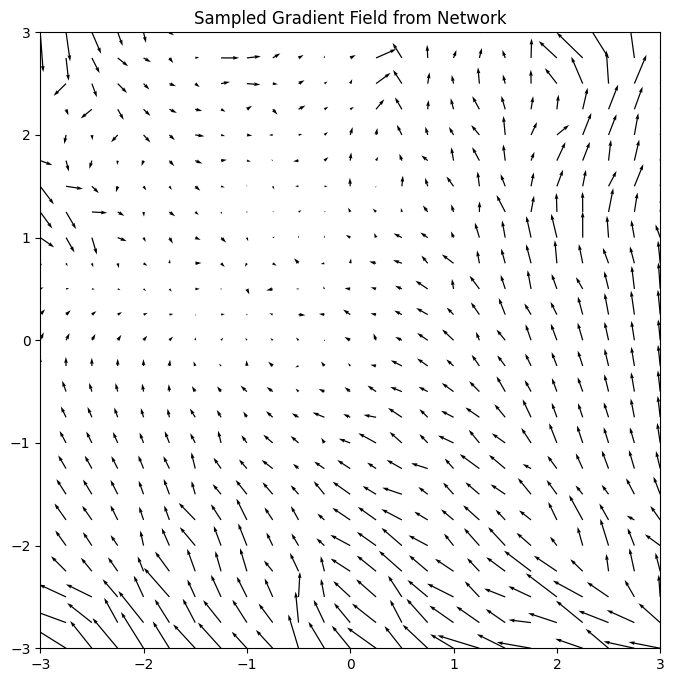

In [10]:
def plot_gradient_field(net):
    net.eval()
    # 生成采样点（这里用均匀网格采样）
    x = torch.linspace(-3, 3, 25)
    y = torch.linspace(-3, 3, 25)
    X, Y = torch.meshgrid(x, y, indexing='xy')
    points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)
    
    with torch.no_grad():
        gradients = 100 * net(points)  # 直接获取网络预测的梯度（得分函数值）
    
    plt.figure(figsize=(8, 8))
    plt.quiver(X, Y, gradients[:, 0].reshape(X.shape), gradients[:, 1].reshape(Y.shape),
               scale_units='xy', scale=1, width=0.002)
    plt.title('Sampled Gradient Field from Network')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()
plot_gradient_field(net)

这个问题的出现是因为神经网络从原始分布中采样时，大部分的样本点都来自于高概率的区域，而低概率区域则会被忽略。这会导致神经网络在训练时无法学习到低概率区域的细节，从而影响 $s_{\theta}(x)$ 的拟合效果。

更数学一点的解释是，公式$$\frac{1}{2}\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}[\|\nabla_{\mathbf{x}}\log p_{\mathrm{data}}(\mathbf{x})-s_{\boldsymbol{\theta}}(\mathbf{x})\|_{2}^{2}]~~~\text{(Fisher divergence)}$$

将内部函数与 $p_{data}$ 进行加权，因此 $p_{data}$ 取值低的地方，在积分后会被忽略。

### 退火朗之万动力学 (Annealed Langevin Dynamics)

为了解决上述问题，我们往 $p(x)$ 中加入噪声 $\epsilon$，得到 $p_1(x)$，这时原始概率密度函数中的低密度区域被缩小了，因此 $s_{1}(x)$ 能够很好地拟合 $p_1(x)$。

然而 $p_1(x)$ 是一个噪声分布，因此 $s_{1}(x)$ 并不能很好地拟合原始分布 $p(x)$。因此我们需要对模型进行修正。

下面这张图可以看出，分布在加入高斯噪声后最终会收敛为正态分布（DDPM前向）

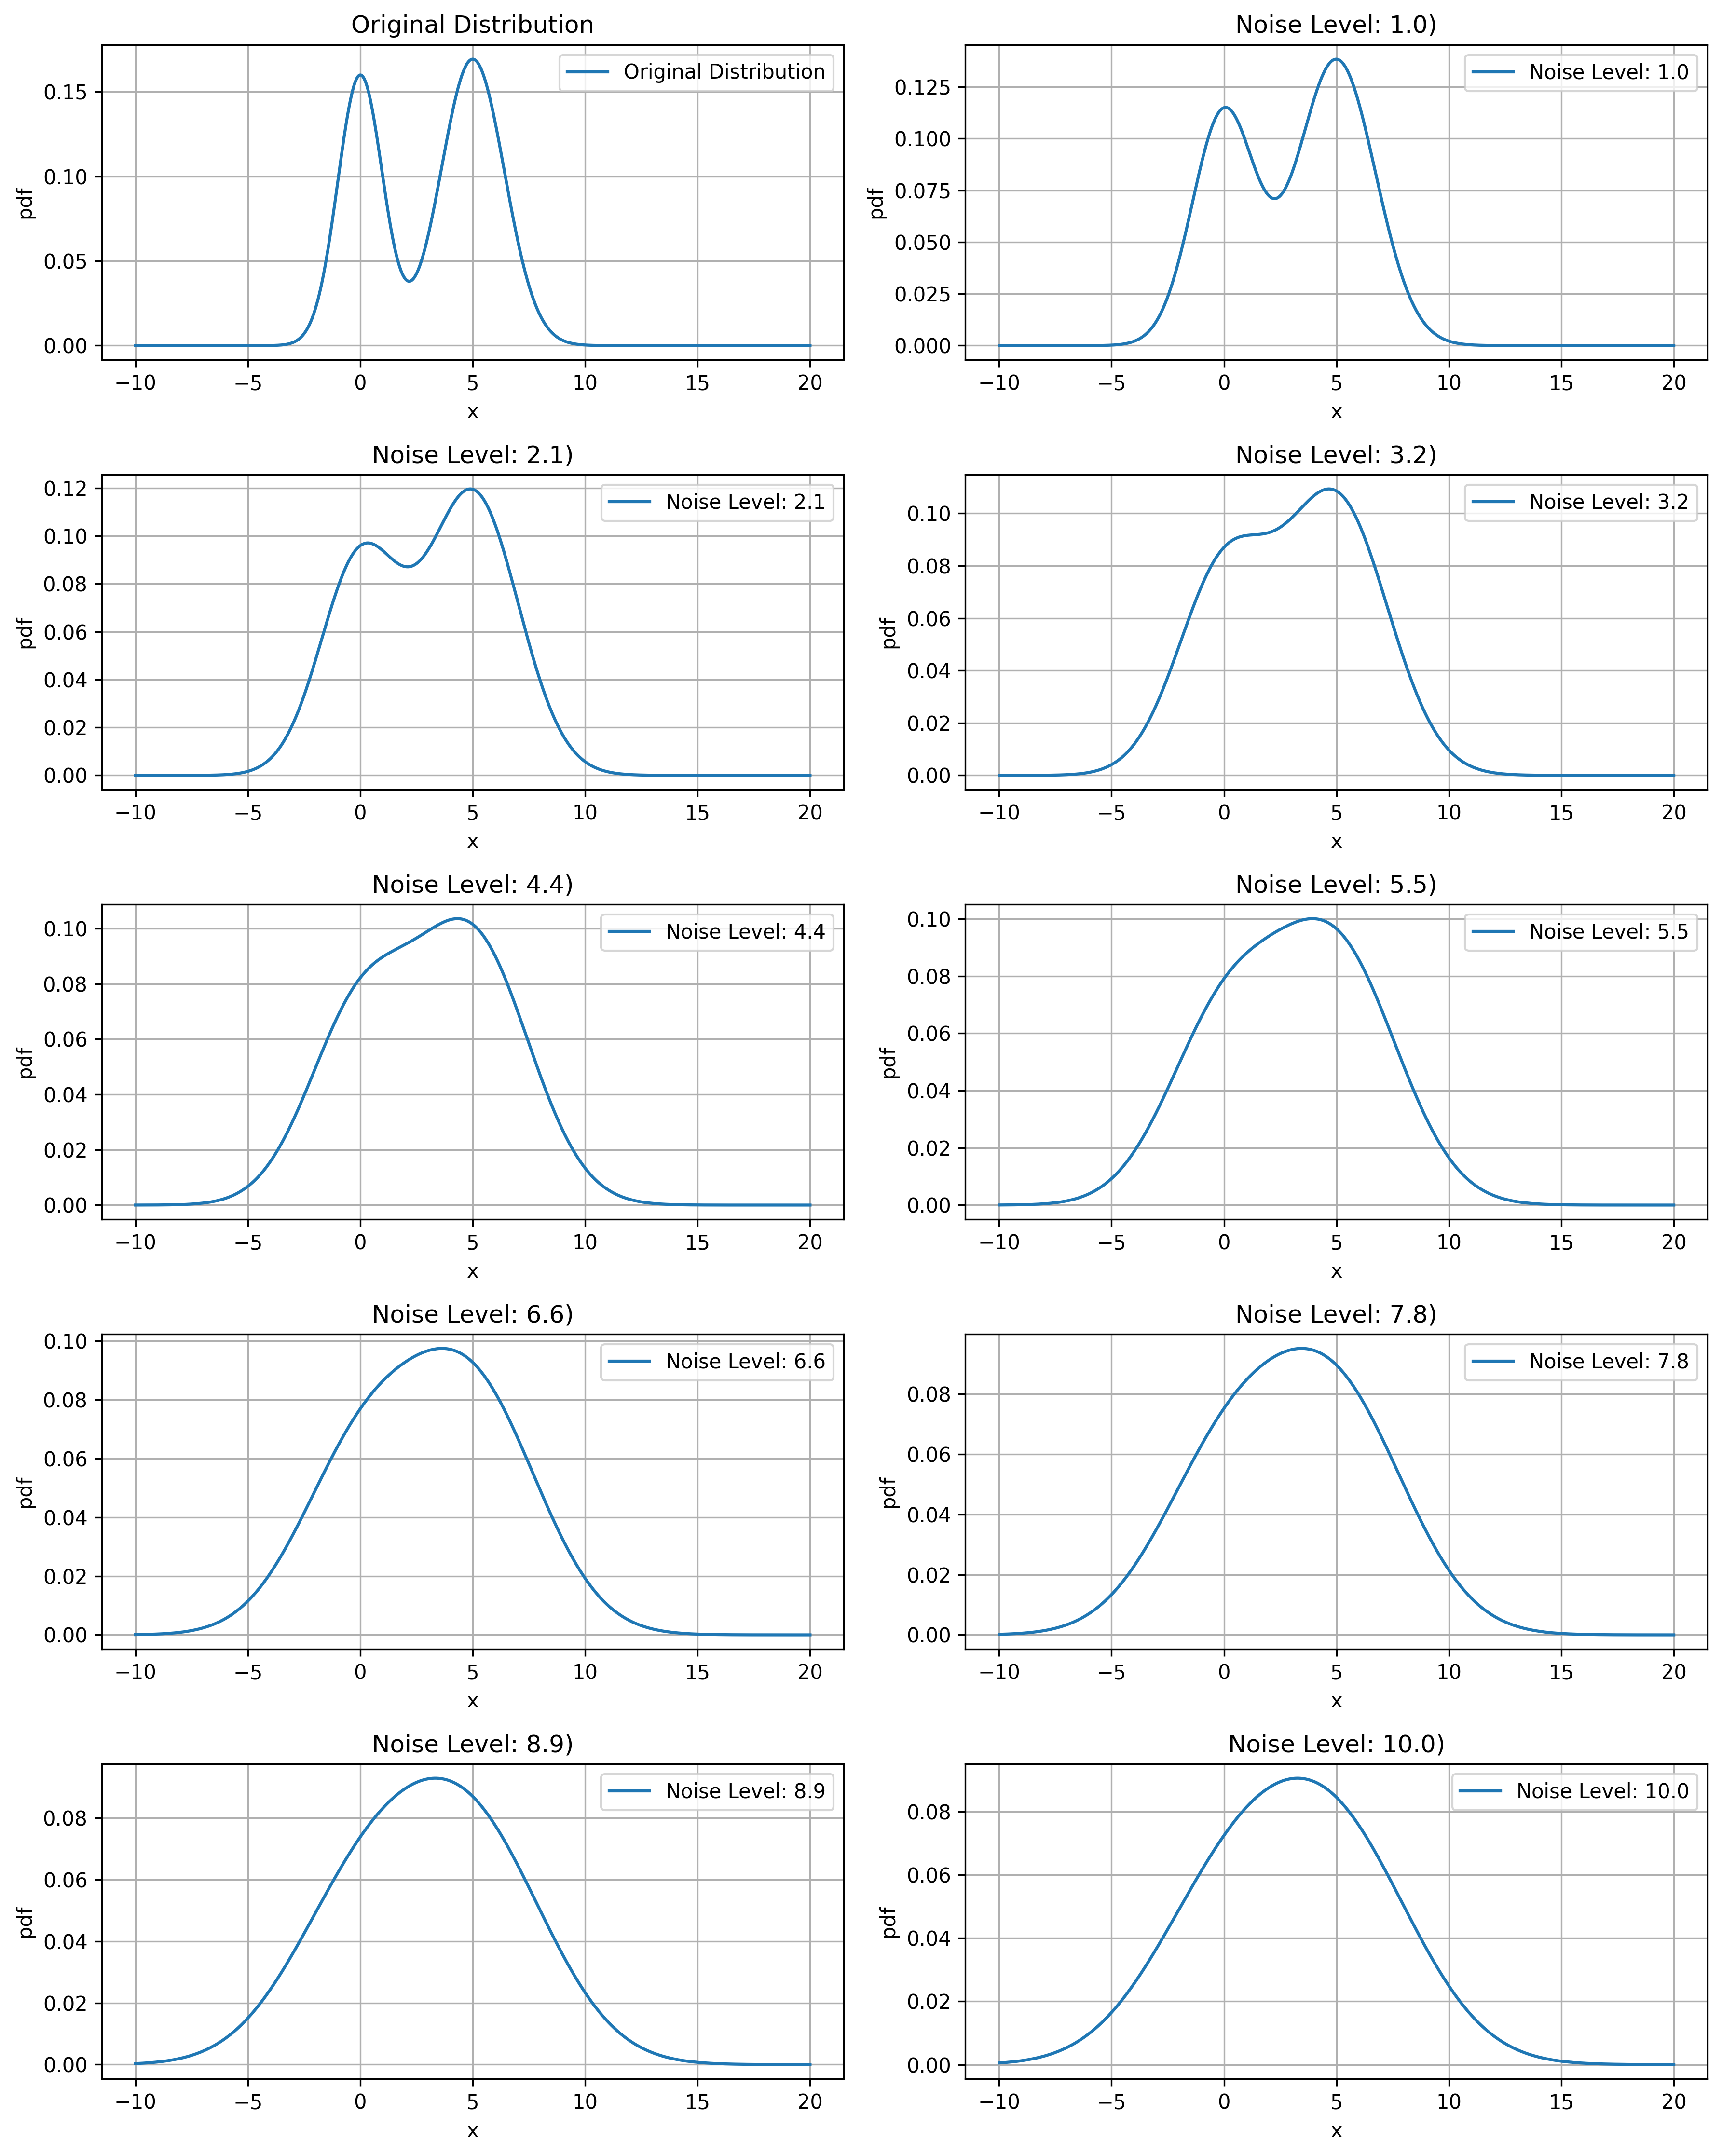

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 300

# 定义混合正态分布的概率密度函数
def mixed_pdf(x):
    return 0.4 * norm.pdf(x, 0, 1) + 0.6 * norm.pdf(x, 5, np.sqrt(2))

# 定义加入噪声后的分布的概率密度函数
def noisy_pdf(x, noise_level):
    return 0.4 * norm.pdf(x, 0, np.sqrt(1 + noise_level)) + 0.6 * norm.pdf(x, 5, np.sqrt(2 + noise_level))

# 设置 x 范围
x = np.linspace(-10, 20, 1000)

# 创建包含 10 个子图的画布
fig, axes = plt.subplots(5, 2, figsize=(12, 15))
axes = axes.flatten()

# 绘制原始混合分布
axes[0].plot(x, mixed_pdf(x), label='Original Distribution')
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('pdf')
axes[0].legend()
axes[0].grid(True)

# 逐步加入噪声并绘制分布
noise_levels = np.linspace(1, 10, 9)
for i, noise_level in enumerate(noise_levels):
    axes[i + 1].plot(x, noisy_pdf(x, noise_level), label=f'Noise Level: {noise_level:.1f}')
    axes[i + 1].set_title(f'Noise Level: {noise_level:.1f})')
    axes[i + 1].set_xlabel('x')
    axes[i + 1].set_ylabel('pdf')
    axes[i + 1].legend()
    axes[i + 1].grid(True)

plt.tight_layout()
plt.show()

因此我们定义多个递增的噪声量级($\{\sigma_i\}_{i=1}^L$)，那么我们需要训练一个神经网络 $s_{\theta}(\mathrm x ,\sigma_i)$ 预测 $p_{\sigma_i}(\mathrm x)$。正是因为噪声的扰动稀释了低密度的区域，因此噪声函数的拟合效果会更好。

$$\mathcal{L} = \sum_{i = 1}^{L} \sigma_{i}^{2} \mathbb{E}_{p_{\sigma_{i}}(\mathbf{x})} \left[ \left\lVert \nabla_{\mathbf{x}} \log p_{\sigma_{i}}(\mathbf{x}) - \mathbf{s}_{\theta}(\mathbf{x}) \right\rVert^{2} \right]$$
其中 $p(x)$ 可由重参数化表示出。

接下来进行朗之万引导，假设我们在 $\sigma_T$ 处进行采样，得到的采样点为 $x_1^{(0)},x_2^{(0)},...,x_n^{(0)}$，根据朗之万方程得到 $x_1^{(1)},x_2^{(1)},...,x_n^{(1)}$，我们将 $x_1^{(1)},x_2^{(1)},...,x_n^{(1)}$ 作为新的采样点，重复上述过程。

在这个过程中，我们在标准的高斯分布中随机采样，最初得到的点在真实分布中可能并非高概率密度的点，因此执行朗之万引导，只要引导是有效的（也就是只要得分函数是“符合”的），我们就可以逐步退火，收敛到高概率密度的点。在此过程中，神经网络为我们提供一个 __势能场__。以上所说的是离散化的模型，我们之后会介绍连续化的模型。

> 在论文中，作者的要求是：$p_{\sigma_{min}}$ 中添加的噪声量必须足够小，使得它近似于原数据分布。

__引入噪声的根本目的：便于拟合分布，执行朗之万引导__

> 论文里管这个叫做 PREDICTOR-CORRECTOR SAMPLERS

## 连续化的情形：随机微分方程

当我们的时间步足够多的时候，可以视为连续过程，并用SDE表征。此时，加噪过程可以由一个简单的随机微分方程表示：
$$
\mathrm d X_t = \sigma (t) \mathrm dW_t
$$
其逆方程（去噪）为：
$$\mathrm{d}\mathbf{x}_t = -\sigma(t)^2 \underbrace{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_t)}_{Score~Function} \, \mathrm{d}t + \sigma(t) \, \mathrm{d}\mathbf{\tilde{w}}_t$$
在离散情况下 $p_t$ 的意思是加噪 $t$ 步后得到的概率密度函数。
优化目标变为：
$$\mathbb{E}_{t\in\mathcal{U}(0,T)}\mathbb{E}_{p_{t}(\mathbf{x})}\left[g^{2}(t)\left\lVert\nabla_{\mathbf{x}} \log p_{t}(\mathbf{x}) - \mathbf{s}_{\theta}(\mathbf{x})\right\rVert^{2}\right]$$

通过逆方程我们可以生成新的样本，即从 $s_{\theta}(x,t)$ 中采样。

### 概率流ODE：由得分函数确定的编码

如果去掉上述逆方程中的随机项，则得到一个确定性的反向路径，称为概率流ODE：
$$\mathrm{d}\mathbf{x}_t = -\sigma(t)^2 \underbrace{\nabla_{\mathbf{x}} \log p_t(\mathbf{x}_t)}_{Score~Function}\mathrm d t$$
由于该过程是确定的，我们可以将其视为一种编码，因此可以操纵图像的生成过程。并且由于它的 __“双射”__ 性质，只要知道初始的采样点和得分函数，我们就可以对生成图片的概率值进行评估。

> 为什么是双射呢？因为前向过程实质上仅由数据分布决定（数据分布决定了得分函数）

整个基于SDE框架就是：我们在正向过程在图像中加噪声训练神经网络做score matching，估计出得分函数。然后在反向过程中从高斯噪声通过逆向sde过程生成出数据分布的样本。

### 随机微分方程框架下的模型
#### SMLD
SMLD加噪过程可以写为：
$$\left\{
\begin{array}{l}
\mathbf{x}_{i}=\mathbf{x}+\sigma_{i}\mathbf{z}\\
\mathbf{x}_{i - 1}=\mathbf{x}+\sigma_{i-1}\mathbf{z}
\end{array}
\right.$$

相减，并利用概率论公式：
$$
\begin{align*}
\mathbf{x}_{i}-\mathbf{x}_{i - 1}&=\sigma_{i}\mathbf{z}-\sigma_{i - 1}\mathbf{z}\\
\mathbf{x}_{i}&=\mathbf{x}_{i - 1}+\sqrt{\sigma_{i}^{2}-\sigma_{i - 1}^{2}}\mathbf{z}
\end{align*}$$

连续化，得到
$$\mathbf{x}(t+\Delta t)=\mathbf{x}(t)+\sqrt{\frac{\mathrm d \sigma^2(t)}{\mathrm dt}}\underbrace{\mathbf{z}(t)\sqrt{\mathrm dt}}_{维纳过程的微分}

$$\mathrm{d}\mathbf{x} = \sqrt{\frac{\mathrm{d}\sigma^{2}(t)}{\mathrm{d}t}} \mathrm{d}\mathbf{w}$$

该SDE被称为 Variance Exploding SDE，因为我们的前向过程实际上是直接向图片中注入高斯噪声。（这一点与DDPM的前向公式不同），因此噪声的方差是爆炸的。

#### DDPM

DDPM的前向过程由$$\mathbf{x}_i=\sqrt{1-\beta_i}\mathbf{x}_{i-1}+\sqrt{\beta_i}\mathbf{z}_{i-1}$$给出

连续化为SDE，可得：$$\mathrm{d}\mathbf{x}=-\frac{1}{2}\beta(t)\mathbf{x}\mathrm{d}t+\sqrt{\beta(t)}\mathrm{d}\mathbf{w}$$
根据DDPM的理论，对于 $\beta$ 我们通常取较小的值，因此该方差是缩紧的，我们称之为 Variance Preserving SDE。

__因此，本质上两个扩散模型都可以写为__ $dx=f(x,t)dt+g(t)dw$ __的形式。__

## 可控生成

假设我们已经有了一个分类器和分类信号 $y$，那么我们拥有 $p(y|x)$，需要使用 $p(x|y)$ 进行采样，从而生成带有标签 $y$ 的样本。由于得分函数的思想：
$$
p(x|y) = \frac{p(y|x)p(x)}{p(y)}
$$

$$\nabla_{\mathbf{x}}\log p(\mathbf{x}\mid\mathbf{y})=\nabla_{\mathbf{x}}\log p(\mathbf{x})+\nabla_{\mathbf{x}}\log p(\mathbf{y}\mid\mathbf{x})-[\nabla_{\mathbf{x}}\log p(\mathbf{y})]=\underbrace{\nabla_{\mathbf{x}}\log p(\mathbf{x})}_{得分函数}+\underbrace{\nabla_{\mathbf{x}}\log p(\mathbf{y}\mid\mathbf{x}}_{已知})$$
$$

因此只需要根据我们训练出的模型就可以进行可控生成了。